In [1]:
!pip install geopandas
!pip install rioxarray

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2
import geopandas as gpd
from google.colab import drive
import os
import pickle
import rioxarray
from pyproj import CRS
import fiona

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/DREAMS - Zhiang/Projects/Rock Traits/data')
print(os.listdir())

     |████████████████████████████████| 994 kB 10.2 MB/s 
     |████████████████████████████████| 6.3 MB 9.2 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 
     |████████████████████████████████| 46 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.7.0-py3-none-any.whl size=53826 sha256=21aceb5c04d50cc6c35aa35d54976e6107177148ca4fd0537f8bbb2b23d9828e
  Stored in directory: /root/.cache/pip/wheels/64/25/e2/1d0324f336102268cae46738e21018b35b23a5adc3f9088a38
Successfully built rioxarray
Mounted at /content/drive
['README', 'C3_sk.jpg', 'registered_instances_c3_rgbd1.pickle', 'registered_instances_c3_rgbd1_refined.pickle', 'registered_instances_c3_rgbd1_refined_update.pickle', 'C3.tif', 'c3_rocks', 'registered_instances_c3_rgbd1_update.pickle', 'registered_instances_c3_rgbd1_upd

## Read skeleton image

In [2]:
skeleton = cv2.imread("C3_sk.jpg", cv2.IMREAD_GRAYSCALE)
skeleton_2d = skeleton > 237
sk_pixel_coords = np.asarray(np.where(skeleton_2d)).transpose()
sk_pixel_up, sk_pixel_down = sk_pixel_coords[0, 0], sk_pixel_coords[0, -1]

"""  
      v
 |------->
 |
u|
 V
(u, v)
"""

print(sk_pixel_up, sk_pixel_down)

42 3117


## create line shapefile

In [3]:
# open a tif raster and read attributes 
c3 = rioxarray.open_rasterio("C3.tif")
h_size, v_size = c3.rio.resolution()
h_start, v_start, h_end, v_end= c3.rio.bounds()

print(c3.rio.bounds())

def pixel2coord(pixel):
  return [h_start + pixel[1]*h_size, v_end + pixel[0]*v_size]

(372333.78378156334, 4145784.9609071277, 372544.16285686305, 4146294.8455599267)


In [4]:
# create LineString shapefile
# ref: https://hatarilabs.com/ih-en/how-to-create-a-pointlinepolygon-shapefile-with-python-and-fiona-tutorial
# 1. define schema
schema = {
    'geometry':'LineString',
    'properties':[('name','str')]
}

# 2. open a write file
lineShp = fiona.open('skeleton/skeleton_Line.shp', mode='w', driver='ESRI Shapefile', schema = schema, crs = c3.rio.crs)

sk_pts = [pixel2coord(sk_pixel) for sk_pixel in sk_pixel_coords]

# 3. add lines to file
rowDict = {'geometry' : {'type':'LineString', 'coordinates': sk_pts}, 'properties': {'name': 'middle' }}
lineShp.write(rowDict)

# 4. write file
lineShp.close()

In [ ]:
sk_shape = gpd.read_file("skeleton/skeleton_Line.shp")
sk_shape.plot()

In [6]:
# create Point shapefile
# ref: https://hatarilabs.com/ih-en/how-to-create-a-pointlinepolygon-shapefile-with-python-and-fiona-tutorial
# 1. define schema
schema = {
    'geometry':'Point',
    'properties':[('name','str')]
}

# 2. open a write file
pointShp = fiona.open('skeleton/skeleton_Point.shp', mode='w', driver='ESRI Shapefile', schema = schema, crs = c3.rio.crs)

# 3. add lines to file
sk_pts = [pixel2coord(sk_pixel) for sk_pixel in sk_pixel_coords]

for sk_pt in sk_pts: 
  rowDict = {'geometry' : {'type':'Point', 'coordinates': sk_pt}, 'properties': {'name': 'middle' }}
  pointShp.write(rowDict)

# 4. write file
pointShp.close()

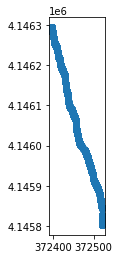

In [7]:
sk_shape = gpd.read_file("skeleton/skeleton_Point.shp")
sk_shape.plot()